In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import pymc3 as pm
import matplotlib.pylab as plt
import theano.tensor as tt
sns.set_style('white')

DATA = '../data/clean/'

Check for the number of available compute cores

In [2]:
import multiprocessing

multiprocessing.cpu_count()

4

## Data import

Line list to extract cases

In [3]:
line_list = pd.read_csv(DATA + 'line_list.csv')
line_list.head()

,id,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
0,389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
1,707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
2,1762.0,2015-04-14,KhU,2015-01-04,0.279261,1.0,1.0,0.0,NaN,0.0,True,4.0,2015.0
3,2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
4,6465.0,2015-05-12,UB,2013-12-18,1.314168,1.0,0.0,0.0,NaN,0.0,False,5.0,2015.0


Extract and plot confirmed counts

In [38]:
confirmed_counts = pd.read_csv(DATA + 'confirmed_counts.csv', index_col=0)
confirmed_counts.tail()

,"[0, 1)","[1, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
date_onset,,,,,,,,,,
2016-05-08,318.0,97.0,83.0,119.0,180.0,155.0,152.0,109.0,63.0,41.0
2016-05-22,293.0,79.0,58.0,81.0,131.0,141.0,105.0,87.0,40.0,36.0
2016-06-05,179.0,71.0,39.0,53.0,70.0,62.0,40.0,45.0,20.0,21.0
2016-06-19,77.0,21.0,7.0,21.0,17.0,13.0,3.0,15.0,12.0,7.0
2016-07-03,12.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0


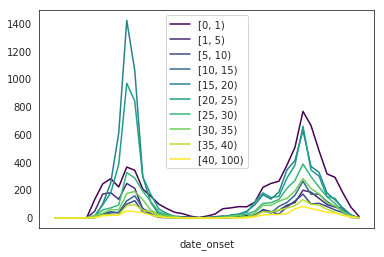

In [39]:
confirmed_counts.plot(cmap='viridis');

In order to account for change in the underlying population, we need the number of births in 2015 and 2016 (Source: [Wikipedia](https://en.wikipedia.org/wiki/Demographics_of_Mongolia#Registered_births_and_deaths))

In [6]:
births = 82130, 79920

We will employ the contact matrix for Mongolia, as estimated by [Prem et al. 2017](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005697#sec020)

In [7]:
B_prem = pd.read_csv(DATA + 'mongolia_prem.csv').values[:9, :9]
B_prem

array([[ 4.40123661,  1.76393655,  0.91943738,  0.62449763,  1.04620724,
         1.48232365,  1.59726926,  1.27263358,  0.69913779],
       [ 1.51664206,  5.57982055,  1.63679975,  0.52656607,  0.37649241,
         0.83552993,  1.0698524 ,  1.04200163,  0.77666399],
       [ 0.56530473,  2.43013564,  9.17372545,  1.33873141,  0.67890573,
         0.56166434,  0.75227034,  0.97884946,  0.97725743],
       [ 0.36238309,  0.73595028,  3.88089151, 12.32915786,  2.48410474,
         1.11449654,  0.79194079,  1.04438411,  1.08448104],
       [ 0.69060422,  0.49460207,  0.65441906,  4.38870495,  6.8744335 ,
         2.87783706,  1.69684851,  1.35746918,  1.11479572],
       [ 1.13165827,  0.59517343,  0.33830222,  1.24692768,  3.31035503,
         4.03747616,  2.29742657,  1.66957878,  1.29603167],
       [ 1.11906529,  1.42978486,  1.12904181,  0.68832499,  1.51871499,
         2.32775238,  2.87889204,  2.1302899 ,  1.51514744],
       [ 1.0230335 ,  1.46318255,  1.28889523,  0.93261004,  0

In [61]:
B_prem.shape

(9, 9)

Expand contact matrix to include infants; treat them the same as 1-4 year-olds.

In [70]:
B_prem_exp = np.zeros((10, 10))
B_prem_exp[1:, 1:] = B_prem.copy()
B_prem_exp[:2, :2] = B_prem_exp[1, 1]
B_prem_exp[0, 2:] = B_prem[0, 1:]
B_prem_exp[2:, 0] = B_prem[1:, 0]
B_prem_exp

array([[ 4.40123661,  4.40123661,  1.76393655,  0.91943738,  0.62449763,
         1.04620724,  1.48232365,  1.59726926,  1.27263358,  0.69913779],
       [ 4.40123661,  4.40123661,  1.76393655,  0.91943738,  0.62449763,
         1.04620724,  1.48232365,  1.59726926,  1.27263358,  0.69913779],
       [ 1.51664206,  1.51664206,  5.57982055,  1.63679975,  0.52656607,
         0.37649241,  0.83552993,  1.0698524 ,  1.04200163,  0.77666399],
       [ 0.56530473,  0.56530473,  2.43013564,  9.17372545,  1.33873141,
         0.67890573,  0.56166434,  0.75227034,  0.97884946,  0.97725743],
       [ 0.36238309,  0.36238309,  0.73595028,  3.88089151, 12.32915786,
         2.48410474,  1.11449654,  0.79194079,  1.04438411,  1.08448104],
       [ 0.69060422,  0.69060422,  0.49460207,  0.65441906,  4.38870495,
         6.8744335 ,  2.87783706,  1.69684851,  1.35746918,  1.11479572],
       [ 1.13165827,  1.13165827,  0.59517343,  0.33830222,  1.24692768,
         3.31035503,  4.03747616,  2.29742657

$R_0$ as estimated from this contact matrix

In [71]:
evs = np.linalg.eigvals(B_prem).real
max(evs[np.isreal(evs)])

17.686930739035084

Import the underlying population sizes, by province:

In [9]:
population = pd.read_csv(DATA + '../clean/denominators.csv', index_col=0)
population.head()

,Total,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70+
Province,,,,,,,,,,,,,,,,
Arkhangai,92896,10440,8360,7883,9249,9469,8207,6856,6824,6294,5498,4643,3266,2202,1237,2468
Bayan-Ulgii,93165,11655,10219,9929,8794,8872,8531,7207,6199,5713,4633,3842,2747,1665,1006,2153
Bayankhongor,79310,9760,7429,6675,7812,7992,7436,6280,5806,5165,4383,3714,2436,1480,1008,1934
Bulgan,60324,6415,5351,4556,5423,5587,4977,4499,4592,4426,4066,3494,2619,1666,877,1776
Gobi-Altai,56698,5953,5392,5046,5778,5631,4837,4401,4345,3994,3389,2730,1974,1064,706,1458


Age classes above 40 will be aggregated into a single group.

In [10]:
pop_classes = population.iloc[:, 1:9].copy()
pop_classes['40+'] = population.iloc[:, 9:].sum(1)
pop_classes.head()

,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40+
Province,,,,,,,,,
Arkhangai,10440,8360,7883,9249,9469,8207,6856,6824,25608
Bayan-Ulgii,11655,10219,9929,8794,8872,8531,7207,6199,21759
Bayankhongor,9760,7429,6675,7812,7992,7436,6280,5806,20120
Bulgan,6415,5351,4556,5423,5587,4977,4499,4592,18924
Gobi-Altai,5953,5392,5046,5778,5631,4837,4401,4345,15315


In [11]:
age_group_index = pop_classes.columns.str.strip()
age_group_index

Index(['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40+'],
      dtype='object')

In [12]:
pop_classes_total = pop_classes.sum().values

In [13]:
pop_classes_total

array([ 522675,  418444,  352776,  386296,  427388,  448107,  379846,
        348235, 1264181])

Break out infants from 0-4 group. Will use average of 2015 and 2016 births, and subtract them from 0-4's.

In [54]:
mean_births = int(np.mean(births))
N = [mean_births, pop_classes_total[0] - mean_births]
N.extend(pop_classes_total[1:])
N = np.array(N)

In [55]:
N

array([  81025,  441650,  418444,  352776,  386296,  427388,  448107,
        379846,  348235, 1264181])

Try to obtain susceptible proportion from coverage history

In [16]:
coverage = pd.read_csv(DATA + 'coverage.csv', index_col=0)

In [17]:
coverage.tail(20)

,MCV1,MCV2,SIA 1994 (M),SIA 1996 (M),SIA 2000 (M),SIA 2007 (M),SIA 2012 (MR)
Age,,,,,,,
19,0.89,0.00,0.0,0.98,0.96,0.00,0.00
18,0.91,0.00,0.0,0.00,0.96,0.97,0.00
17,0.93,0.00,0.0,0.00,0.96,0.97,0.87
16,0.93,0.75,0.0,0.00,0.96,0.97,0.89
15,0.92,0.95,0.0,0.00,0.00,0.97,0.91
14,0.95,0.96,0.0,0.00,0.00,0.97,0.88
13,0.98,0.98,0.0,0.00,0.00,0.97,0.95
12,0.98,0.98,0.0,0.00,0.00,0.97,0.95
11,0.99,0.98,0.0,0.00,0.00,0.97,0.96


In [18]:
age_classes = [0,1,5,10,15,20,25,30,35,40,100]
age_slices = [slice(age_classes[i], age_classes[i+1]) for i in range(len(age_classes)-1)]

In [19]:
n_age_classes = len(age_classes) - 1

In [20]:
efficacy = 0.85

Dependent MCV immunization

In [21]:
immune_MCV1 = coverage.MCV1 * 0.8
immune_MCV2 = (1 - immune_MCV1) * coverage.MCV2 * 0.8

In [22]:
MCV_immunity = immune_MCV2 + immune_MCV1

Text(0, 0.5, 'Susceptibility')

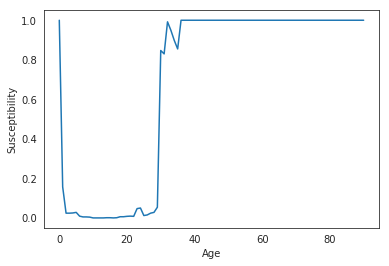

In [23]:
susceptibility = (1 - coverage*efficacy).prod(axis=1).round(3).sort_index()
susceptibility.plot()
plt.ylabel('Susceptibility')

In [24]:
p_susc = susceptibility.groupby(pd.cut(susceptibility.index, age_classes)).mean()

Down-sample susceptibility to age groups.

In [25]:
downsample = lambda x: np.array([x[s].mean() for s in age_slices])
downsample(susceptibility)

array([1.    , 0.0585, 0.0112, 0.0012, 0.0038, 0.0254, 0.0276, 0.9032,
       0.971 , 1.    ])

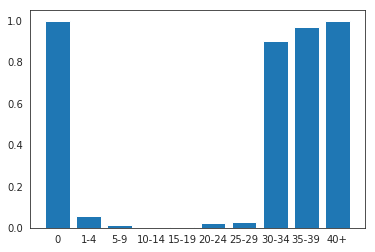

In [26]:
age_labels = ['0', '1-4', '5-9', '10-14', '15-19', '20-24', '25-29', 
                    '30-34', '35-39', '40+']
plt.bar(range(len(age_slices)), downsample(susceptibility), 
        tick_label=age_labels);

*These susceptibility rates can't be true given the distribution of cases that were observed!*

### SIA

Create a time x age matrix of SIA vaccinations to account for intervention

In [27]:
sia_2015 = pd.read_csv(DATA + 'sia_2015.csv', index_col=0)
sia_2016 = pd.read_csv(DATA + 'sia_2016.csv', index_col=0)
sia_2015.head()

,0,1-4,5-9
Arkhangai,860,7364,1837
Bayan-Ulgii,1361,9069,1872
Bayankhongor,928,6992,2019
Bulgan,574,4494,1430
Gobi-Altai,494,4490,1276


In [28]:
sia_2015_total = (sia_2015.sum()
                          .reindex(pd.Index(age_labels))
                          .fillna(0)
                          .astype(int))
sia_2015_total

0         34302
1-4      247851
5-9       65532
10-14         0
15-19         0
20-24         0
25-29         0
30-34         0
35-39         0
40+           0
dtype: int64

In [29]:
sia_2016.sum()

15-19     78105
20-24    186022
25-29    230733
30-34     54439
dtype: int64

In [30]:
sia_2016_total = (sia_2016.sum()
                          .reindex(pd.Index(age_labels))
                          .fillna(0)
                          .astype(int))
sia_2016_total

0             0
1-4           0
5-9           0
10-14         0
15-19     78105
20-24    186022
25-29    230733
30-34     54439
35-39         0
40+           0
dtype: int64

In [31]:
sia = pd.DataFrame(index=confirmed_counts.index, columns=pd.Index(age_labels)).fillna(0)

In [32]:
sia.loc['2016-05-22'] = sia_2016_total
sia.loc[['2015-05-24', '2015-06-07', '2015-06-21']] = [sia_2015_total/4,
                                                       sia_2015_total/2,
                                                       sia_2015_total/4]

In [33]:
sia

,0,1-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40+
date_onset,,,,,,,,,,
2015-01-18,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-15,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-15,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-29,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-12,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-26,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-05-10,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
sia_vacc = sia.cumsum(0).values

### Measles dynamics

$$\prod_{t=0}^T Pr(I_t | S_{t-1}, I_{t-1}) Pr(S_t | I_t, S_{t-1})$$

Input data

In [40]:
I = confirmed_counts.values.astype(int)
I.shape

(39, 10)

In [41]:
I_age = I.sum(0)

In [42]:
lab_samples = line_list.dropna(subset=['date_lab']).copy()
lab_samples.head()

,id,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
0,389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
1,707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
3,2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
8,20835.0,2015-11-25,UB,2015-09-01,0.238193,1.0,1.0,1.0,2015-12-01,0.0,True,11.0,2015.0
9,21053.0,2015-12-02,UB,2014-11-19,1.062286,0.0,1.0,1.0,2015-12-14,0.0,False,12.0,2015.0


In [43]:
clinic_confirmed = lab_samples.query('confirmed==1').dropna(subset=['age_years']).copy()
clinic_confirmed.shape

(5846, 13)

In [44]:
clinic_confirmed['age_group'] = pd.cut(clinic_confirmed.age_years, age_classes, labels=np.arange(len(age_slices)))

In [45]:
clinic_confirmed.dropna(subset=['age_years']).groupby('age_group')['labconfirmed'].mean()

age_group
0    0.768957
1    0.657143
2    0.791489
3    0.503497
4    0.528487
5    0.539967
6    0.533007
7    0.752212
8    0.727273
9    0.372093
Name: labconfirmed, dtype: float64

In [46]:
age_midpoints = np.array([0.5, 3, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 70])

Model specification

In [47]:
from theano import shared, function
from theano.tensor.shared_randomstreams import RandomStreams

In [48]:
confirmed, age, age_group = clinic_confirmed[['labconfirmed', 'age_years', 'age_group']].values.T

In [49]:
age_group = age_group.astype(int)
age = age.astype(float)

In [50]:
n_knots = 20
knots = np.linspace(age.min(), age.max(), n_knots)

In [51]:
def interpolate(x0, y0, x):
    
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [73]:
with pm.Model() as model:
    
    # Confirmation sub-model
    σ = pm.HalfNormal('σ', 5)
    y = pm.GaussianRandomWalk('y', sd=σ, shape=n_knots)
    α = interpolate(knots, y, age)
    π = pm.invlogit(α)
        
    confirmation = pm.Bernoulli('confirmation', π, observed=confirmed)
    
    # Calculate age group probabilities of confirmation
    α_group = interpolate(knots, y, age_midpoints)
    p_confirm = pm.Deterministic('p_confirm', pm.invlogit(α_group))
    
    # Basic reproduction number centered on the dominant eigenvector of the contact matrix
    R_0 = pm.Normal('R_0', max(evs[np.isreal(evs)]), sd=3.5)
    
    # Initial susceptibles (assume no information)
    S_0 = pm.Uniform('S_0', 0, N, shape=n_age_classes, testval=N*0.8)
    
    # Susceptibles over time, removing individuals vaccinated by SIA
    S = S_0 - shared(sia_vacc) - shared(I.cumsum(axis=0))
    
    # Force of infection
    λ = S * (I.dot(B_prem_exp) / N) + 0.001
    
    # Effective reproductive number
    R_t = pm.Deterministic('R_t', S.sum(1) * R_0 / N.sum())
    
    # Adjust for confirmation bias
    λ_obs = λ / p_confirm
    
    # Infections likelihood
    infections = pm.Poisson('infections', λ_obs[:-1], observed=I[1:])



In [74]:
model.check_test_point()

σ_log__               -0.77
y                    -43.75
R_0                   -2.17
S_0_interval__       -18.33
confirmation       -4052.14
infections       -786039.82
Name: Log-probability of test_point, dtype: float64

In [75]:
with model:
    
    trace = pm.sample(1000, tune=3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S_0, R_0, y, σ]
Sampling 2 chains: 100%|██████████| 8000/8000 [12:19<00:00, 10.81draws/s]
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6331519635330601, but should be close to 0.8. Try to increase the number of tuning steps.


Convergence check

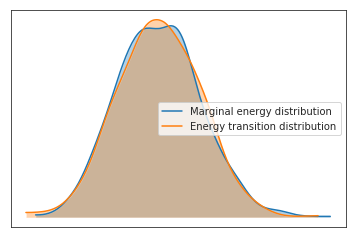

In [76]:
pm.energyplot(trace);

Estimate of initial susceptibles

In [77]:
pm.summary(trace, varnames=['S_0']).round(0)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
S_0__0,45798.0,97.0,3.0,45602.0,45988.0,1213.0,1.0
S_0__1,259724.0,292.0,7.0,259113.0,260272.0,1485.0,1.0
S_0__2,76143.0,309.0,9.0,75522.0,76712.0,1269.0,1.0
S_0__3,7758.0,425.0,14.0,6913.0,8557.0,857.0,1.0
S_0__4,85494.0,38.0,1.0,85423.0,85570.0,1186.0,1.0
S_0__5,192513.0,48.0,1.0,192419.0,192605.0,1567.0,1.0
S_0__6,234474.0,52.0,2.0,234376.0,234576.0,1156.0,1.0
S_0__7,57443.0,77.0,2.0,57301.0,57588.0,1748.0,1.0
S_0__8,7310.0,396.0,13.0,6510.0,8011.0,1048.0,1.0
S_0__9,14903.0,4812.0,181.0,7018.0,23745.0,596.0,1.0


For comparison, estimates without confirmation bias correction:

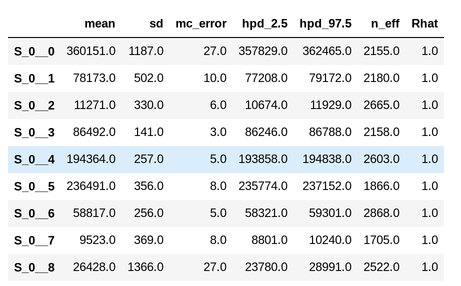

GridSpec(1, 1)

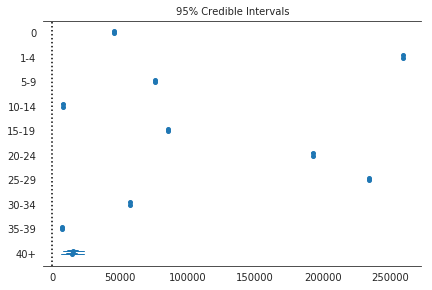

In [78]:
pm.forestplot(trace, varnames=['S_0'], ylabels=age_labels, rhat=False)

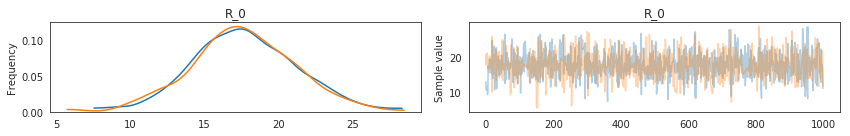

In [79]:
pm.traceplot(trace, varnames=['R_0']);

Trajectory of effective R

GridSpec(1, 2, width_ratios=[3, 1])

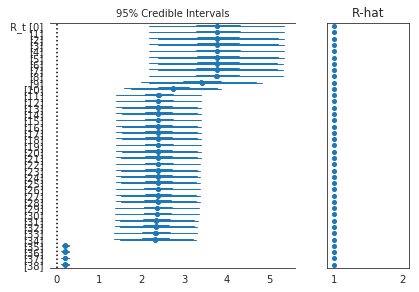

In [80]:
pm.forestplot(trace, varnames=['R_t'])

Prior for vaccine efficacy coefficient

(array([  1.,   1.,   3.,   3.,  17.,  29.,  56., 147., 262., 481.]),
 array([0.47823629, 0.5304097 , 0.58258311, 0.63475652, 0.68692992,
        0.73910333, 0.79127674, 0.84345015, 0.89562356, 0.94779696,
        0.99997037]),
 <a list of 10 Patch objects>)

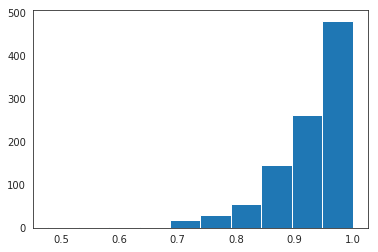

In [81]:
plt.hist(pm.Beta.dist(12, 1).random(size=1000))

In [82]:
with pm.Model() as uncertain_vacc_model:
    
    # Confirmation sub-model
    σ = pm.HalfNormal('σ', 5)
    y = pm.GaussianRandomWalk('y', sd=σ, shape=n_knots)
    α = interpolate(knots, y, age)
    π = pm.invlogit(α)
        
    confirmation = pm.Bernoulli('confirmation', π, observed=confirmed)
    
    # Calculate age group probabilities of confirmation
    α_group = interpolate(knots, y, age_midpoints)
    p_confirm = pm.Deterministic('p_confirm', pm.invlogit(α_group))
    
    # Basic reproduction number centered on the dominant eigenvector of the contact matrix
    R_0 = pm.Normal('R_0', max(evs[np.isreal(evs)]), sd=3.5)
    
    # Initial susceptibles (assume no information)
    S_0 = pm.Uniform('S_0', 0, N, shape=n_age_classes, testval=N*0.8)
    
    p_vacc = pm.Beta('p_vacc', 12, 1, shape=n_age_classes)
    
    # Susceptibles over time, removing individuals vaccinated by SIA
    S = S_0 - sia_vacc*p_vacc - shared(I.cumsum(axis=0))
    
    # Force of infection
    λ = S * (I.dot(B_prem_exp) / N) + 0.001
    
    # Effective reproductive number
    R_t = pm.Deterministic('R_t', S.sum(1) * R_0 / N.sum())
    
    # Adjust for confirmation bias
    λ_apparent = λ / p_confirm
    
    # Infections likelihood
    infections = pm.Poisson('infections', λ_apparent[:-1], observed=I[1:])



In [83]:
uncertain_vacc_model.check_test_point()

σ_log__                 -0.77
y                      -43.75
R_0                     -2.17
S_0_interval__         -18.33
p_vacc_logodds__       -10.41
confirmation         -4052.14
infections         -794040.81
Name: Log-probability of test_point, dtype: float64

In [84]:
with uncertain_vacc_model:
    
    unc_trace = pm.sample(1000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_vacc, S_0, R_0, y, σ]
Sampling 2 chains: 100%|██████████| 6000/6000 [09:32<00:00, 10.48draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


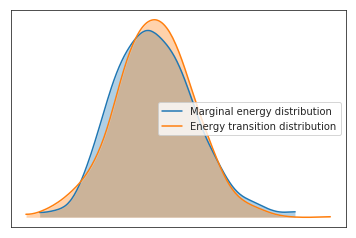

In [85]:
pm.energyplot(unc_trace);

GridSpec(1, 1)

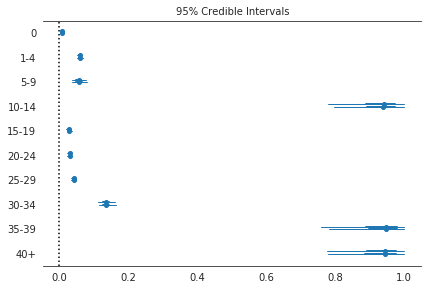

In [86]:
pm.forestplot(unc_trace, varnames=['p_vacc'], ylabels=age_labels, rhat=False)

GridSpec(1, 2, width_ratios=[3, 1])

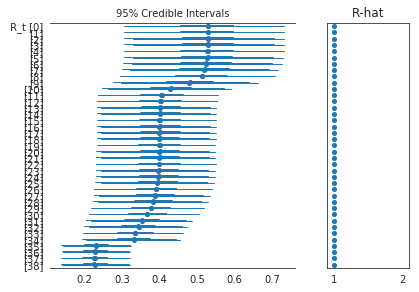

In [87]:
pm.forestplot(unc_trace, varnames=['R_t'])

GridSpec(1, 1)

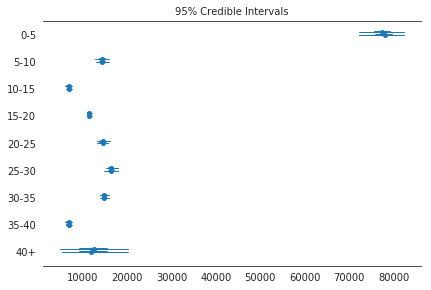

In [54]:
pm.forestplot(unc_trace, varnames=['S_0'], ylabels=age_labels, rhat=False)